In [ ]:
def time_shift(audio_data, shift_max=0.2):
  shift = np.random.randint(len(audio_data) * shift_max)
  return np.roll(audio_data, shift)

def change_volume(audio_data, gain_factor=1.5):
  return audio_data * gain_factor

def add_noise(audio_data, noise_factor=0.005):
  noise = np.random.randn(len(audio_data))
  augmented_audio = audio_data + noise_factor * noise
  return augmented_audio

def pitch_shift(audio_data, sample_rate, n_steps=2):
  return librosa.effects.pitch_shift(audio_data, sr=sample_rate, n_steps=n_steps)


In [ ]:
def augment_audio(audio_data, sample_rate):
    if np.random.rand() < 0.5:
        audio_data = pitch_shift(audio_data, sample_rate, n_steps=np.random.randint(-5, 5))
    if np.random.rand() < 0.5:
        audio_data = add_noise(audio_data, noise_factor=np.random.uniform(0.001, 0.01))
    if np.random.rand() < 0.5:
        audio_data = change_volume(audio_data, gain_factor=np.random.uniform(0.7, 1.3))
    if np.random.rand() < 0.5:
        audio_data = time_shift(audio_data, shift_max=0.2)
    return audio_data


In [ ]:
def preprocess_data(source_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5,augment=True):
    data = {
        "mapping":[],
        "labels": [],
        "mfcc": [],
        }

    samples_per_segment = int(SAMPLES_PER_TRACK/num_segments)

    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment/hop_length)


    # Let's browse each file, slice it and generate the 13 band mfcc for each slice.
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(source_path)):
      for file in filenames:
        if os.path.join(dirpath,file) != '/content/drive/MyDrive/Data/genres_original/jazz/jazz.00054.wav':
          file_path = os.path.join(dirpath,file)
          signal,sample_rate = librosa.load(file_path,sr=SAMPLE_RATE)

          if augment:
            signal = augment_audio(signal,sample_rate)

          for d in range(num_segments):
            start = samples_per_segment * d
            finish = start + samples_per_segment

            mfcc = librosa.feature.mfcc(y=signal[start:finish],sr=sample_rate,n_mfcc=num_mfcc,n_fft=n_fft,hop_length=hop_length)
            mfcc = mfcc.T

            if len(mfcc) == num_mfcc_vectors_per_segment:
              data["mfcc"].append(mfcc.tolist())
              data["labels"].append(i-1)

    # Let's write the dictionary in a json file.
    with open(json_path, 'w') as f:
        json.dump(data, f)
    f.close()

In [ ]:
import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import json
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import math


SOURCE_PATH = '/content/drive/MyDrive/Data/genres_original/'
JSON_PATH = '/content/drive/MyDrive/data.json'
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

def load_data(json_path):

    with open(json_path, 'r') as f:
        data = json.load(f)
    f.close()

    # Let's load our data into numpy arrays for TensorFlow compatibility.
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    return X, y

def prepare_datasets(inputs, targets, split_size,validataion_size):

    # Creating a validation set and a test set.
    inputs_train, inputs_val, targets_train, targets_val = train_test_split(inputs, targets, test_size=split_size)
    inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs_train, targets_train, test_size=validataion_size)

    # Our CNN model expects 3D input shape.
    inputs_train = inputs_train[..., np.newaxis]
    inputs_val = inputs_val[..., np.newaxis]
    inputs_test = inputs_test[..., np.newaxis]

    return inputs_train, inputs_val, inputs_test, targets_train, targets_val, targets_test

def predict(model, X, y):
    """Predict a single sample using the trained model

    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))

def plot_performance(hist):

    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
inputs, targets = load_data(json_path=JSON_PATH)
Xtrain, Xval, Xtest, ytrain, yval, ytest = prepare_datasets(inputs, targets, 0.25,0.2)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def design_model2(input_shape):

    model = tf.keras.models.Sequential([

        tf.keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=input_shape, kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),  # reduced dropout rate for early layers

        tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),  # adjusted dropout

        tf.keras.layers.Conv2D(256, (2,2), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
        tf.keras.layers.MaxPooling2D((2,2), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Example usage
input_shape = (130, 13, 1)
model = design_model2(input_shape)
model.summary()

# Assuming you have Xtrain, ytrain, Xval, yval already loaded
# One-hot encode the labels
# ytrain_one_hot = tf.keras.utils.to_categorical(ytrain, num_classes=10)
# yval_one_hot = tf.keras.utils.to_categorical(yval, num_classes=10)

# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_acc', mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(Xtrain, ytrain, validation_data=(Xval, yval), epochs=50, batch_size=32,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])


Mounted at /content/drive
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 11, 128)      1280      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 6, 128)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 64, 6, 128)        512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 64, 6, 128)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 4, 256)        295168    
                                                                 
 max_pooling2d_1 (MaxPoolin  (

188/188 [==============================] - 11s 53ms/step - loss: 4.2039 - accuracy: 0.3307 - val_loss: 4.4906 - val_accuracy: 0.3416 - lr: 0.0010
Epoch 2/50
187/188 [============================>.] - ETA: 0s - loss: 3.1916 - accuracy: 0.4153

188/188 [==============================] - 9s 49ms/step - loss: 3.1924 - accuracy: 0.4151 - val_loss: 2.5754 - val_accuracy: 0.4650 - lr: 0.0010
Epoch 3/50
188/188 [==============================] - ETA: 0s - loss: 2.4595 - accuracy: 0.4861

188/188 [==============================] - 9s 50ms/step - loss: 2.4595 - accuracy: 0.4861 - val_loss: 2.2391 - val_accuracy: 0.5222 - lr: 0.0010
Epoch 4/50
188/188 [==============================] - ETA: 0s - loss: 2.1986 - accuracy: 0.5440

188/188 [==============================] - 9s 49ms/step - loss: 2.1986 - accuracy: 0.5440 - val_loss: 2.1019 - val_accuracy: 0.5747 - lr: 0.0010
Epoch 5/50
187/188 [============================>.] - ETA: 0s - loss: 2.0403 - accuracy: 0.5834

188/188 [==============================] - 9s 50ms/step - loss: 2.0396 - accuracy: 0.5835 - val_loss: 2.0804 - val_accuracy: 0.5755 - lr: 0.0010
Epoch 6/50
188/188 [==============================] - ETA: 0s - loss: 1.9438 - accuracy: 0.6198

188/188 [==============================] - 9s 49ms/step - loss: 1.9438 - accuracy: 0.6198 - val_loss: 1.8866 - val_accuracy: 0.6348 - lr: 0.0010
Epoch 7/50
188/188 [==============================] - ETA: 0s - loss: 1.8638 - accuracy: 0.6421

188/188 [==============================] - 9s 49ms/step - loss: 1.8638 - accuracy: 0.6421 - val_loss: 2.0458 - val_accuracy: 0.5715 - lr: 0.0010
Epoch 8/50
188/188 [==============================] - ETA: 0s - loss: 1.8103 - accuracy: 0.6675

188/188 [==============================] - 9s 49ms/step - loss: 1.8103 - accuracy: 0.6675 - val_loss: 1.9409 - val_accuracy: 0.6223 - lr: 0.0010
Epoch 9/50
187/188 [============================>.] - ETA: 0s - loss: 1.7432 - accuracy: 0.6867

188/188 [==============================] - 9s 50ms/step - loss: 1.7432 - accuracy: 0.6869 - val_loss: 1.9192 - val_accuracy: 0.6280 - lr: 0.0010
Epoch 10/50
187/188 [============================>.] - ETA: 0s - loss: 1.7213 - accuracy: 0.6962

188/188 [==============================] - 9s 49ms/step - loss: 1.7219 - accuracy: 0.6959 - val_loss: 1.8426 - val_accuracy: 0.6528 - lr: 0.0010
Epoch 11/50
188/188 [==============================] - ETA: 0s - loss: 1.6882 - accuracy: 0.7056

188/188 [==============================] - 9s 49ms/step - loss: 1.6882 - accuracy: 0.7056 - val_loss: 1.7779 - val_accuracy: 0.6892 - lr: 0.0010
Epoch 12/50
187/188 [============================>.] - ETA: 0s - loss: 1.6494 - accuracy: 0.7261

188/188 [==============================] - 9s 50ms/step - loss: 1.6498 - accuracy: 0.7261 - val_loss: 1.8451 - val_accuracy: 0.6688 - lr: 0.0010
Epoch 13/50
187/188 [============================>.] - ETA: 0s - loss: 1.6355 - accuracy: 0.7398

188/188 [==============================] - 9s 50ms/step - loss: 1.6373 - accuracy: 0.7393 - val_loss: 1.9050 - val_accuracy: 0.6664 - lr: 0.0010
Epoch 14/50
187/188 [============================>.] - ETA: 0s - loss: 1.6551 - accuracy: 0.7375

188/188 [==============================] - 9s 50ms/step - loss: 1.6550 - accuracy: 0.7373 - val_loss: 1.8831 - val_accuracy: 0.6680 - lr: 0.0010
Epoch 15/50
188/188 [==============================] - ETA: 0s - loss: 1.5875 - accuracy: 0.7687

188/188 [==============================] - 9s 49ms/step - loss: 1.5875 - accuracy: 0.7687 - val_loss: 1.9517 - val_accuracy: 0.6608 - lr: 0.0010
Epoch 16/50
187/188 [============================>.] - ETA: 0s - loss: 1.5977 - accuracy: 0.7771

188/188 [==============================] - 9s 49ms/step - loss: 1.5984 - accuracy: 0.7768 - val_loss: 1.9021 - val_accuracy: 0.6924 - lr: 0.0010
Epoch 17/50
188/188 [==============================] - ETA: 0s - loss: 1.4478 - accuracy: 0.8296

188/188 [==============================] - 9s 49ms/step - loss: 1.4478 - accuracy: 0.8296 - val_loss: 1.6662 - val_accuracy: 0.7621 - lr: 1.0000e-04
Epoch 18/50
188/188 [==============================] - ETA: 0s - loss: 1.3420 - accuracy: 0.8660

188/188 [==============================] - 9s 50ms/step - loss: 1.3420 - accuracy: 0.8660 - val_loss: 1.6318 - val_accuracy: 0.7717 - lr: 1.0000e-04
Epoch 19/50
187/188 [============================>.] - ETA: 0s - loss: 1.3008 - accuracy: 0.8700

188/188 [==============================] - 9s 49ms/step - loss: 1.3022 - accuracy: 0.8696 - val_loss: 1.6250 - val_accuracy: 0.7685 - lr: 1.0000e-04
Epoch 20/50
187/188 [============================>.] - ETA: 0s - loss: 1.2784 - accuracy: 0.8793

188/188 [==============================] - 9s 50ms/step - loss: 1.2785 - accuracy: 0.8793 - val_loss: 1.5942 - val_accuracy: 0.7813 - lr: 1.0000e-04
Epoch 21/50
187/188 [============================>.] - ETA: 0s - loss: 1.2258 - accuracy: 0.8952

188/188 [==============================] - 9s 50ms/step - loss: 1.2257 - accuracy: 0.8952 - val_loss: 1.5740 - val_accuracy: 0.7853 - lr: 1.0000e-04
Epoch 22/50
187/188 [============================>.] - ETA: 0s - loss: 1.1927 - accuracy: 0.9051

188/188 [==============================] - 9s 50ms/step - loss: 1.1926 - accuracy: 0.9052 - val_loss: 1.5451 - val_accuracy: 0.7877 - lr: 1.0000e-04
Epoch 23/50
187/188 [============================>.] - ETA: 0s - loss: 1.1705 - accuracy: 0.9081

188/188 [==============================] - 9s 50ms/step - loss: 1.1708 - accuracy: 0.9080 - val_loss: 1.5367 - val_accuracy: 0.7918 - lr: 1.0000e-04
Epoch 24/50
188/188 [==============================] - ETA: 0s - loss: 1.1485 - accuracy: 0.9065

188/188 [==============================] - 9s 50ms/step - loss: 1.1485 - accuracy: 0.9065 - val_loss: 1.5249 - val_accuracy: 0.7930 - lr: 1.0000e-04
Epoch 25/50
187/188 [============================>.] - ETA: 0s - loss: 1.1136 - accuracy: 0.9151

188/188 [==============================] - 9s 50ms/step - loss: 1.1135 - accuracy: 0.9152 - val_loss: 1.5091 - val_accuracy: 0.7897 - lr: 1.0000e-04
Epoch 26/50
187/188 [============================>.] - ETA: 0s - loss: 1.1019 - accuracy: 0.9191

188/188 [==============================] - 9s 49ms/step - loss: 1.1019 - accuracy: 0.9192 - val_loss: 1.4898 - val_accuracy: 0.7966 - lr: 1.0000e-04
Epoch 27/50
188/188 [==============================] - ETA: 0s - loss: 1.0741 - accuracy: 0.9184

188/188 [==============================] - 9s 50ms/step - loss: 1.0741 - accuracy: 0.9184 - val_loss: 1.4695 - val_accuracy: 0.7950 - lr: 1.0000e-04
Epoch 28/50
188/188 [==============================] - ETA: 0s - loss: 1.0529 - accuracy: 0.9234

188/188 [==============================] - 9s 49ms/step - loss: 1.0529 - accuracy: 0.9234 - val_loss: 1.4678 - val_accuracy: 0.7869 - lr: 1.0000e-04
Epoch 29/50
187/188 [============================>.] - ETA: 0s - loss: 1.0277 - accuracy: 0.9283

188/188 [==============================] - 9s 50ms/step - loss: 1.0314 - accuracy: 0.9274 - val_loss: 1.4634 - val_accuracy: 0.7918 - lr: 1.0000e-04
Epoch 30/50
187/188 [============================>.] - ETA: 0s - loss: 1.0004 - accuracy: 0.9303

188/188 [==============================] - 9s 50ms/step - loss: 1.0003 - accuracy: 0.9304 - val_loss: 1.4397 - val_accuracy: 0.7958 - lr: 1.0000e-04
Epoch 31/50
188/188 [==============================] - ETA: 0s - loss: 0.9900 - accuracy: 0.9321

188/188 [==============================] - 9s 50ms/step - loss: 0.9900 - accuracy: 0.9321 - val_loss: 1.4195 - val_accuracy: 0.7982 - lr: 1.0000e-04
Epoch 32/50
187/188 [============================>.] - ETA: 0s - loss: 0.9821 - accuracy: 0.9276

188/188 [==============================] - 9s 49ms/step - loss: 0.9820 - accuracy: 0.9277 - val_loss: 1.4100 - val_accuracy: 0.7905 - lr: 1.0000e-04
Epoch 33/50
188/188 [==============================] - ETA: 0s - loss: 0.9465 - accuracy: 0.9431

188/188 [==============================] - 9s 49ms/step - loss: 0.9465 - accuracy: 0.9431 - val_loss: 1.3680 - val_accuracy: 0.8042 - lr: 1.0000e-04
Epoch 34/50
188/188 [==============================] - ETA: 0s - loss: 0.9250 - accuracy: 0.9437

188/188 [==============================] - 9s 49ms/step - loss: 0.9250 - accuracy: 0.9437 - val_loss: 1.3739 - val_accuracy: 0.8034 - lr: 1.0000e-04
Epoch 35/50
187/188 [============================>.] - ETA: 0s - loss: 0.9156 - accuracy: 0.9405

188/188 [==============================] - 9s 49ms/step - loss: 0.9155 - accuracy: 0.9406 - val_loss: 1.3740 - val_accuracy: 0.7990 - lr: 1.0000e-04
Epoch 36/50
187/188 [============================>.] - ETA: 0s - loss: 0.8954 - accuracy: 0.9422

188/188 [==============================] - 9s 49ms/step - loss: 0.8954 - accuracy: 0.9422 - val_loss: 1.3511 - val_accuracy: 0.8042 - lr: 1.0000e-04
Epoch 37/50
187/188 [============================>.] - ETA: 0s - loss: 0.8786 - accuracy: 0.9447

188/188 [==============================] - 9s 48ms/step - loss: 0.8788 - accuracy: 0.9446 - val_loss: 1.3486 - val_accuracy: 0.7962 - lr: 1.0000e-04
Epoch 38/50
187/188 [============================>.] - ETA: 0s - loss: 0.8698 - accuracy: 0.9433

188/188 [==============================] - 9s 49ms/step - loss: 0.8700 - accuracy: 0.9431 - val_loss: 1.3413 - val_accuracy: 0.7986 - lr: 1.0000e-04
Epoch 39/50
187/188 [============================>.] - ETA: 0s - loss: 0.8511 - accuracy: 0.9472

188/188 [==============================] - 9s 50ms/step - loss: 0.8513 - accuracy: 0.9471 - val_loss: 1.3366 - val_accuracy: 0.7998 - lr: 1.0000e-04
Epoch 40/50
187/188 [============================>.] - ETA: 0s - loss: 0.8300 - accuracy: 0.9519

188/188 [==============================] - 9s 50ms/step - loss: 0.8300 - accuracy: 0.9519 - val_loss: 1.3467 - val_accuracy: 0.7897 - lr: 1.0000e-04
Epoch 41/50
188/188 [==============================] - ETA: 0s - loss: 0.8160 - accuracy: 0.9519

188/188 [==============================] - 9s 49ms/step - loss: 0.8160 - accuracy: 0.9519 - val_loss: 1.2923 - val_accuracy: 0.8070 - lr: 1.0000e-04
Epoch 42/50
188/188 [==============================] - ETA: 0s - loss: 0.7980 - accuracy: 0.9516

188/188 [==============================] - 9s 50ms/step - loss: 0.7980 - accuracy: 0.9516 - val_loss: 1.2798 - val_accuracy: 0.8102 - lr: 1.0000e-04
Epoch 43/50
188/188 [==============================] - ETA: 0s - loss: 0.7904 - accuracy: 0.9534

188/188 [==============================] - 9s 50ms/step - loss: 0.7904 - accuracy: 0.9534 - val_loss: 1.2906 - val_accuracy: 0.8026 - lr: 1.0000e-04
Epoch 44/50
188/188 [==============================] - ETA: 0s - loss: 0.7790 - accuracy: 0.9539

188/188 [==============================] - 9s 50ms/step - loss: 0.7790 - accuracy: 0.9539 - val_loss: 1.2569 - val_accuracy: 0.8030 - lr: 1.0000e-04
Epoch 45/50
188/188 [==============================] - ETA: 0s - loss: 0.7623 - accuracy: 0.9581

188/188 [==============================] - 9s 50ms/step - loss: 0.7623 - accuracy: 0.9581 - val_loss: 1.2511 - val_accuracy: 0.8066 - lr: 1.0000e-04
Epoch 46/50
187/188 [============================>.] - ETA: 0s - loss: 0.7413 - accuracy: 0.9586

188/188 [==============================] - 9s 49ms/step - loss: 0.7417 - accuracy: 0.9584 - val_loss: 1.2315 - val_accuracy: 0.8106 - lr: 1.0000e-04
Epoch 47/50
187/188 [============================>.] - ETA: 0s - loss: 0.7272 - accuracy: 0.9626

188/188 [==============================] - 9s 49ms/step - loss: 0.7279 - accuracy: 0.9624 - val_loss: 1.2347 - val_accuracy: 0.8110 - lr: 1.0000e-04
Epoch 48/50
187/188 [============================>.] - ETA: 0s - loss: 0.7214 - accuracy: 0.9591

188/188 [==============================] - 9s 49ms/step - loss: 0.7213 - accuracy: 0.9591 - val_loss: 1.2353 - val_accuracy: 0.8034 - lr: 1.0000e-04
Epoch 49/50
187/188 [============================>.] - ETA: 0s - loss: 0.7048 - accuracy: 0.9644

188/188 [==============================] - 9s 50ms/step - loss: 0.7057 - accuracy: 0.9638 - val_loss: 1.2152 - val_accuracy: 0.8150 - lr: 1.0000e-04
Epoch 50/50
187/188 [============================>.] - ETA: 0s - loss: 0.6869 - accuracy: 0.9661

188/188 [==============================] - 9s 49ms/step - loss: 0.6880 - accuracy: 0.9658 - val_loss: 1.1942 - val_accuracy: 0.8134 - lr: 1.0000e-04


In [ ]:
model.save('final_model.keras')
# Save only the weights
model.save_weights('model_weights.h5')
from tensorflow.keras.utils import plot_model
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(Xtest, ytest, verbose=2)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
47/47 - 1s - loss: 1.2251 - accuracy: 0.7951 - 504ms/epoch - 11ms/step
Test Accuracy: 79.51%


In [ ]:
# Save the model in the TensorFlow SavedModel format
model.save('my_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
pip install graphviz

In [ ]:
!apt-get -qq install -y graphviz && pip install pydot
import pydot

In [ ]:
def plot_performance(hist):
    # Access history keys to handle the case where 'accuracy' might be used instead of 'acc'
    acc = hist.history.get('accuracy')
    val_acc = hist.history.get('val_accuracy')
    loss = hist.history.get('loss')
    val_loss = hist.history.get('val_loss')

    epochs = range(len(loss))  # Number of epochs

    # Plot accuracy
    if acc and val_acc:
        plt.plot(epochs, acc, 'r', label='Training accuracy')
        plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.figure()

    # Plot loss
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


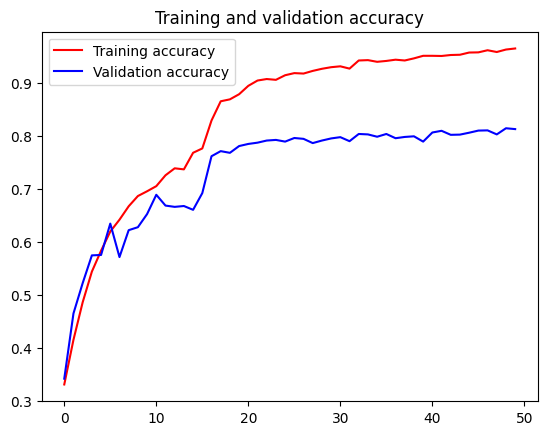

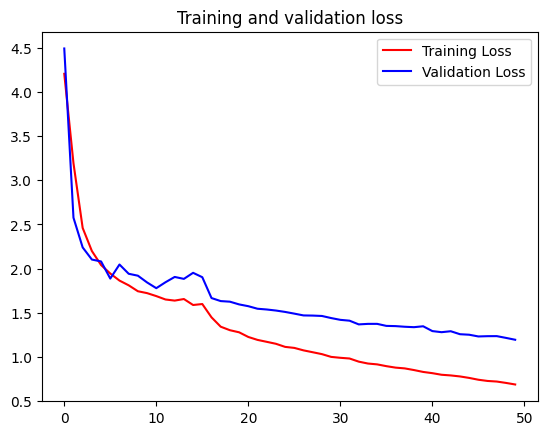

In [ ]:
# prompt: plot the graph of train_acc and val_acc

plot_performance(history)
